In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# import seaborn as sns
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
#Import keras functions

from keras import Sequential
from keras.applications import VGG19,ResNet50
from keras.preprocessing.image import ImageDataGenerator

from keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from keras.utils import to_categorical

In [4]:
from keras.datasets import cifar10
(x_train,y_train),(x_test,y_test)=cifar10.load_data()

In [5]:
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=.3)

In [6]:
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((35000, 32, 32, 3), (35000, 1))
((15000, 32, 32, 3), (15000, 1))
((10000, 32, 32, 3), (10000, 1))


In [7]:
y_train=to_categorical(y_train)
y_val=to_categorical(y_val)
y_test=to_categorical(y_test)

In [8]:
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((35000, 32, 32, 3), (35000, 10))
((15000, 32, 32, 3), (15000, 10))
((10000, 32, 32, 3), (10000, 10))


In [9]:
train_generator = ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip=True,
                                    zoom_range=.1 )

val_generator = ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip=True,
                                    zoom_range=.1)

test_generator = ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip= True,
                                    zoom_range=.1) 

In [10]:
train_generator.fit(x_train)
val_generator.fit(x_val)
test_generator.fit(x_test)

In [11]:
lrr= ReduceLROnPlateau(
                       monitor='val_acc', #Metric to be measured
                       factor=.01, #Factor by which learning rate will be reduced
                       patience=3,  #No. of epochs after which if there is no improvement in the val_acc, the learning rate is reduced
                       min_lr=1e-5) #The minimum learning rate 

In [12]:
base_model_2 = ResNet50(include_top=False,weights='imagenet',input_shape=(32,32,3),classes=y_train.shape[1])

Metal device set to: Apple M1


2022-11-30 19:46:18.568958: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-30 19:46:18.569347: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
model_2=Sequential()
#Add the Dense layers along with activation and batch normalization
model_2.add(base_model_2)
model_2.add(Flatten())


#Add the Dense layers along with activation and batch normalization
model_2.add(Dense(4000,activation=('relu'),input_dim=512))
model_2.add(Dense(2000,activation=('relu'))) 
model_2.add(Dropout(.4))
model_2.add(Dense(1000,activation=('relu'))) 
model_2.add(Dropout(.3))#Adding a dropout layer that will randomly drop 30% of the weights
model_2.add(Dense(500,activation=('relu')))
model_2.add(Dropout(.2))
model_2.add(Dense(10,activation=('softmax'))) #This is the classification layer

In [14]:
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 4000)              8196000   
                                                                 
 dense_1 (Dense)             (None, 2000)              8002000   
                                                                 
 dropout (Dropout)           (None, 2000)              0         
                                                                 
 dense_2 (Dense)             (None, 1000)              2001000   
                                                                 
 dropout_1 (Dropout)         (None, 1000)              0

In [18]:
batch_size= 100
epochs=50
learn_rate=.001

sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
adam=Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)


/Users/shubhamgoyal/tensorflow-test/env/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/shubhamgoyal/tensorflow-test/env/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [19]:
model_2.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

In [22]:
model_2.fit_generator(train_generator.flow(x_train,y_train,batch_size=batch_size),
                     epochs=4,steps_per_epoch=x_train.shape[0]//batch_size,
                     validation_data=val_generator.flow(x_val,y_val,batch_size=batch_size),validation_steps=250,
                      callbacks=[lrr],verbose=1)

Epoch 1/4


/var/folders/d9/7kl5np_95hz69s_vwscxrc8r0000gn/T/ipykernel_79505/1565098847.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_2.fit_generator(train_generator.flow(x_train,y_train,batch_size=batch_size),


350/350 [==============================] - 153s 438ms/step - loss: 0.7447 - accuracy: 0.7669 - lr: 0.0010
Epoch 2/4
350/350 [==============================] - 151s 431ms/step - loss: 0.6353 - accuracy: 0.7994 - lr: 0.0010
Epoch 3/4
350/350 [==============================] - 184s 525ms/step - loss: 0.6376 - accuracy: 0.8028 - lr: 0.0010
Epoch 4/4
350/350 [==============================] - 169s 483ms/step - loss: 0.5741 - accuracy: 0.8173 - lr: 0.0010


In [40]:
y_pred_resnet=model_2.predict(x_test)
y_true=np.argmax(y_test,axis=1)

y_pred_classes = [np.argmax(element) for element in y_pred_resnet]


#Compute the confusion matrix
# confusion_mtx=confusion_matrix(y_true,y_pred_resnet)

313/313 [==============================] - 8s 26ms/step


In [32]:
class_names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [44]:
from sklearn.metrics import confusion_matrix , classification_report
print("Classification Report: \n", classification_report(y_true, y_pred_classes))

Classification Report: 
               precision    recall  f1-score   support

           0       0.61      0.85      0.71      1000
           1       0.86      0.81      0.83      1000
           2       0.48      0.83      0.61      1000
           3       0.61      0.48      0.54      1000
           4       0.76      0.62      0.68      1000
           5       0.87      0.29      0.43      1000
           6       0.87      0.76      0.81      1000
           7       0.85      0.75      0.79      1000
           8       0.61      0.93      0.73      1000
           9       0.93      0.68      0.78      1000

    accuracy                           0.70     10000
   macro avg       0.74      0.70      0.69     10000
weighted avg       0.74      0.70      0.69     10000



In [43]:
y_true

array([3, 8, 8, ..., 5, 1, 7])

In [46]:
confusion_mtx=confusion_matrix(y_true,y_pred_classes)

In [47]:

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

Confusion matrix, without normalization


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

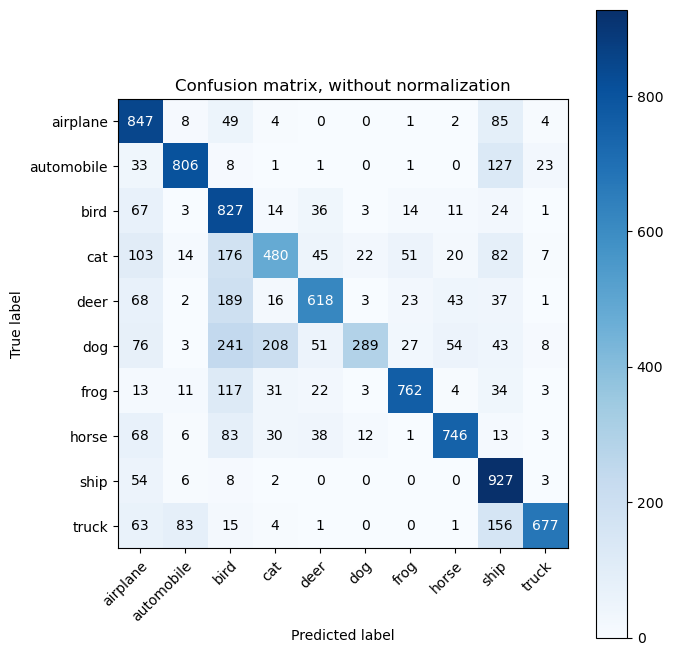

In [49]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred_classes, classes=class_names,
                      title='Confusion matrix, without normalization')

Normalized confusion matrix


<AxesSubplot: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

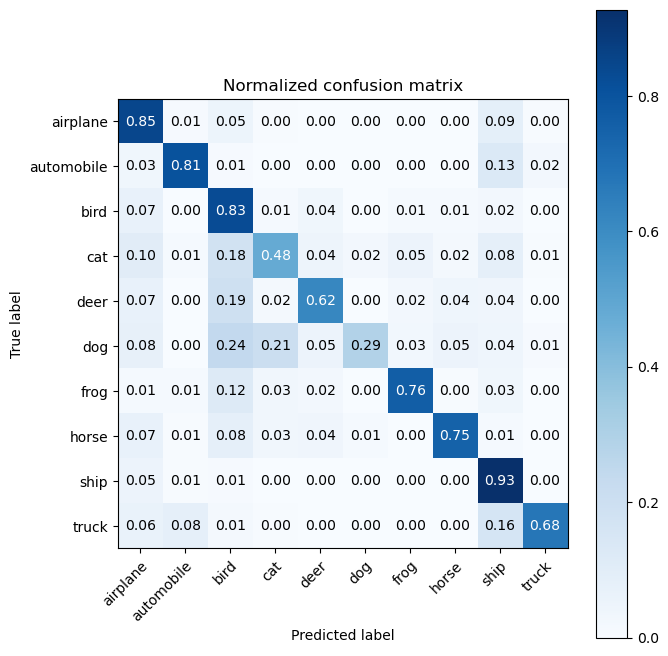

In [51]:
plot_confusion_matrix(y_true, y_pred_classes, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')